In [7]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

# Make the Dataset from Window
- The model that used full vector field performed too well. Let's try using only 1/3 from the back.
- So, x index will be [398:599], y index will be [100:201]
- Concat velocity vector of ux and uy vertically

(100, 200)


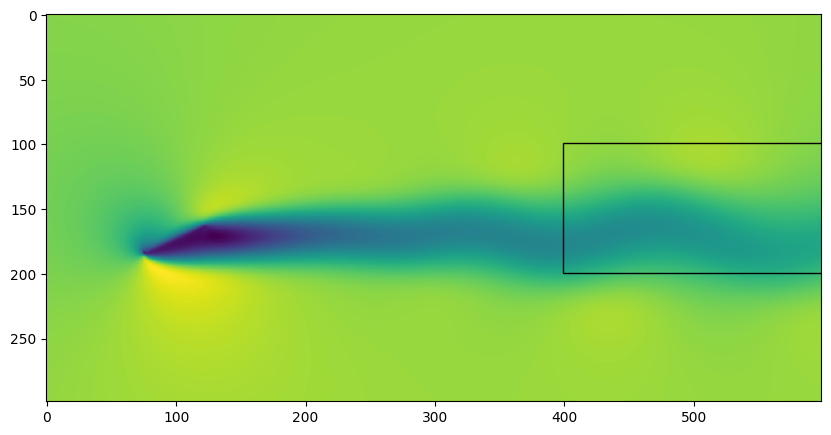

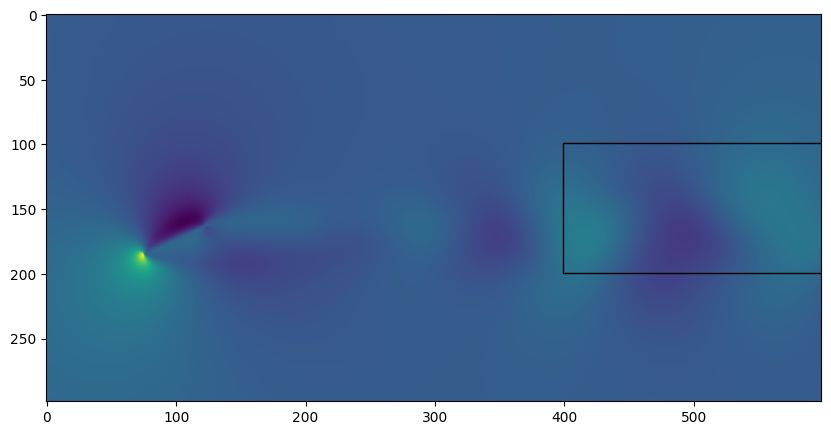

In [2]:
# Window will look like this:

filenames = os.listdir("C:/Users/bono2/Desktop/Pitching Airfoil/original data/")
file_path = "C:/Users/bono2/Desktop/Pitching Airfoil/original data/" + filenames[0]

file = h5py.File(file_path, 'r')
ux = np.array(file['ux'])
uy = np.array(file['uy'])
file.close()


print(ux[0][99:199, 399:599].shape)

# UX
fig, ax = plt.subplots(figsize = (10,20))

# Display the image
ax.imshow(ux[0])

# window = np.zeros(ux[0].shape)
# window[99:199, 399:599] = 100
# ax.imshow(window)

# Create a Rectangle patch
rect = patches.Polygon(np.array([[399, 99], [599, 99], [599, 199], [399, 199]]), closed = True, fill = False)

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


# UY
fig, ax = plt.subplots(figsize = (10,20))

# Display the image
ax.imshow(uy[0])

# window = np.zeros(ux[0].shape)
# window[100:201, 398:599] = 100
# ax.imshow(window)

# Create a Rectangle patch
rect = patches.Polygon(np.array([[399, 99], [599, 99], [599, 199], [399, 199]]), closed = True, fill = False)

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Concern : UY has way small value compared to UX. How will that effect the model's performance
- Normalize ux and uy then concatenate

# Make a HDF5 dataset from it

In [3]:
original_data_dir = "C:/Users/bono2/Desktop/Pitching Airfoil/original data/"
concat_save_dir = "C:/Users/bono2/Desktop/Pitching Airfoil/dataset/window/window_vertical_concat_dataset.hdf5"

filenames = os.listdir(original_data_dir)

first_iter = True
how_many_data = 0

for filename in filenames:
    
    # Get frequency info from filename
    try:
        frequency = (filename.split('p')[1]).split('.')[0]
        if len(frequency) == 1:
            frequency += '0'
        
        frequency = int(frequency)/100
        
        # print(frequency)
        
    except:
        
        # Skip if it is static
        continue
        
        
    # Get alpha info from filename(Just in Case!)
    
    alpha = (filename.split('_')[1])[1:3]
    # print(alpha)

    # Create label
    label = np.array([float(alpha), (frequency)])
    
    # Get the velocity data
    
    file_path = original_data_dir + filename
    file = h5py.File(file_path,'r')
    ux = np.array(file['ux'])[:,99:199, 399:599]
    uy = np.array(file['uy'])[:,99:199, 399:599]
    file.close()
    
    # Concat ux uy in axis 1
    for i in range(0,ux.shape[0]):
        
        u = np.concatenate((ux[i], uy[i]), axis = 0)
        
        # Reshape it into 3 dimensional data
        u = np.array([u])
    
        # Create hdf5 file if first iteration
        if first_iter:
            hdf5 = h5py.File(concat_save_dir, "w")

            hdf5.create_dataset('u', data = u, compression = "gzip", chunks = True, maxshape=(None, 200, 200))
            hdf5.create_dataset('label', data = np.array([[alpha, frequency]], dtype = 'float'), compression = "gzip", chunks = True, maxshape=(None,2)) 

            hdf5.close()

            first_iter = False

        # Else, append
        else:
            hdf5 = h5py.File(concat_save_dir, "a")
            hdf5['u'].resize((hdf5['u'].shape[0] + 1), axis=0)
            hdf5['u'][-1] = u

            hdf5['label'].resize((hdf5['label'].shape[0] + 1), axis=0)
            hdf5['label'][-1] = label
            
            hdf5.close()
        
        how_many_data+=1
    
print(how_many_data)

11216


# Now, split the data into train, validation, test

- Split the indices for each frequency into 8 lists

In [4]:
file = h5py.File(concat_save_dir, 'r')
freq = np.array(file['label'])[:,1]
index = list(range(len(freq)))
file.close()
freq_dic = {}
for i in index:
    freq_dic[i] = freq[i]

idx05, idx10, idx20, idx25, idx30, idx35, idx40, idx50 = [], [], [], [], [], [], [], []

for i, f in enumerate(freq):
    if f == 0.05:
        idx05.append(i)
    elif f == 0.1:
        idx10.append(i)
    elif f == 0.2:
        idx20.append(i)
    elif f == 0.25:
        idx25.append(i)
    elif f == 0.3:
        idx30.append(i)
    elif f == 0.35:
        idx35.append(i)
    elif f == 0.4:
        idx40.append(i)
    elif f == 0.5:
        idx50.append(i)

OSError: Unable to open file (file signature not found)

- Shuffle the divided indices, then slice it into 70 : 15 : 15
- As all data has length of 1402 let's just make everything 2803 produce random index sets of train, validation, test
- train : 982 * 8, validation : 210 * 8, test : 210 * 8
- Then, save this index as pickle

In [5]:
np.random.shuffle(idx05)
np.random.shuffle(idx10)
np.random.shuffle(idx20)
np.random.shuffle(idx25)
np.random.shuffle(idx30)
np.random.shuffle(idx35)
np.random.shuffle(idx40)
np.random.shuffle(idx50)

train_idx = idx05[0:982]+idx10[0:982]+idx20[0:982]+idx25[0:982]+idx30[0:982]+idx35[0:982]+idx40[0:982]+idx50[0:982]
val_idx = idx05[982:1192]+idx10[982:1192]+idx20[982:1192]+idx25[982:1192]+idx30[982:1192]+idx35[982:1192]+idx40[982:1192]+idx50[982:1192]
test_idx = idx05[1192:]+idx10[1192:]+idx20[1192:]+idx25[1192:]+idx30[1192:]+idx35[1192:]+idx40[1192:]+idx50[1192:]

np.random.shuffle(train_idx)
np.random.shuffle(val_idx)
np.random.shuffle(test_idx)

idx = {"train":train_idx, "val":val_idx, "test":test_idx}
with open("index.pickle", 'wb') as file:
    pickle.dump(idx, file)

- Make the dataset based on previous label

In [4]:
train_X = np.zeros((7856, 200, 200, 1)); train_Y = np.zeros((7856, 2))
val_X = np.zeros((1680, 200, 200, 1)); val_Y = np.zeros((1680, 2))
test_X = np.zeros((1680, 200, 200, 1)); test_Y = np.zeros((1680, 2))

In [8]:
with open(r"C:\Users\bono2\Desktop\Pitching Airfoil\dataset\window_normalized\index.pickle", 'rb') as file:
    idx = pickle.load(file)

file = h5py.File(concat_save_dir, 'r')

for i, index in zip(range(train_X.shape[0]), idx['train']):
    train_X[i] = file['u'][index].reshape(200, 200, 1)
    train_Y[i] = file['label'][index]

for i, index in zip(range(val_X.shape[0]), idx['val']):
    val_X[i] = file['u'][index].reshape(200, 200, 1)
    val_Y[i] = file['label'][index]
    
for i, index in zip(range(test_X.shape[0]), idx['test']):
    test_X[i] = file['u'][index].reshape(200, 200, 1)
    test_Y[i] = file['label'][index]

# Zero Centering

In [15]:
# Get mean for zero centering
mean = np.mean(train_X, axis = 0)
train_X -= mean
val_X -= mean
test_X -= mean

np.save("mean.npy", mean)

[[[-1.78771910e-18]
  [ 1.10230901e-18]
  [ 1.38848539e-18]
  ...
  [ 1.79478518e-18]
  [-1.03518122e-18]
  [ 1.66052960e-18]]

 [[ 3.67436337e-19]
  [ 2.60031869e-18]
  [-4.06299796e-19]
  ...
  [-2.18695281e-18]
  [ 1.57926964e-18]
  [ 6.81877049e-19]]

 [[ 1.96790423e-18]
  [-2.49079440e-18]
  [ 1.02104905e-18]
  ...
  [-1.47327839e-18]
  [-1.69586002e-18]
  [ 1.09524293e-19]]

 ...

 [[-2.84763161e-18]
  [ 2.46253007e-18]
  [ 1.31782456e-18]
  ...
  [ 2.11189638e-18]
  [-4.27718861e-19]
  [ 2.98983654e-18]]

 [[ 1.97497031e-18]
  [-4.87559755e-19]
  [-1.55807139e-18]
  ...
  [ 9.62422641e-19]
  [ 1.68658578e-18]
  [ 1.23523971e-18]]

 [[ 2.42013357e-18]
  [ 1.39555147e-18]
  [-3.32105920e-19]
  ...
  [ 1.83861698e-18]
  [ 1.26703708e-18]
  [ 1.93610685e-18]]]


# Min-Max Scaling

In [10]:
train_ux = train_X[:,0:100,:,:]; train_uy = train_X[:,100:200,:,:]
val_ux = val_X[:,0:100,:,:]; val_uy = val_X[:,100:200,:,:]
test_ux = test_X[:,0:100,:,:]; test_uy = test_X[:,100:200,:,:]

ux_max = 0; ux_min = 10000; uy_max = 0; uy_min = 10000

for ux in train_ux:
    M = np.max(ux); m = np.min(ux)
    if ux_max < M:
        ux_max = M
    elif ux_min > m:
        ux_min = m
   
for uy in train_uy:
    M = np.max(uy); m = np.min(uy)
    if uy_max < M:
        uy_max = M
    if uy_min > m:
        uy_min = m
        
print(ux_max, uy_max, ux_min, uy_min)
ux_range = ux_max - ux_min
uy_range = uy_max - uy_min

train_ux /= ux_range; train_uy /= uy_range
val_ux /= ux_range; val_uy /= uy_range
test_ux /= ux_range; test_uy /= uy_range

0.21768159164969525 0.42206638472786406 -0.27516264218431874 -0.44021552408287934


In [11]:
for x, y, i in zip(train_ux, train_uy, range(len(train_uy))):
    train_X[i,0:100,:,:] = x
    train_X[i,100:200,:,:] = y
for x, y, i in zip(val_ux, val_uy, range(len(val_uy))):
    val_X[i,0:100,:,:] = x
    val_X[i,100:200,:,:] = y
for x, y, i  in zip(test_ux, test_uy, range(len(val_uy))):
    test_X[i,0:100,:,:] = x
    test_X[i,100:200,:,:] = y

In [16]:
print(np.mean(train_X, axis = 0))

[[[-1.78771910e-18]
  [ 1.10230901e-18]
  [ 1.38848539e-18]
  ...
  [ 1.79478518e-18]
  [-1.03518122e-18]
  [ 1.66052960e-18]]

 [[ 3.67436337e-19]
  [ 2.60031869e-18]
  [-4.06299796e-19]
  ...
  [-2.18695281e-18]
  [ 1.57926964e-18]
  [ 6.81877049e-19]]

 [[ 1.96790423e-18]
  [-2.49079440e-18]
  [ 1.02104905e-18]
  ...
  [-1.47327839e-18]
  [-1.69586002e-18]
  [ 1.09524293e-19]]

 ...

 [[-2.84763161e-18]
  [ 2.46253007e-18]
  [ 1.31782456e-18]
  ...
  [ 2.11189638e-18]
  [-4.27718861e-19]
  [ 2.98983654e-18]]

 [[ 1.97497031e-18]
  [-4.87559755e-19]
  [-1.55807139e-18]
  ...
  [ 9.62422641e-19]
  [ 1.68658578e-18]
  [ 1.23523971e-18]]

 [[ 2.42013357e-18]
  [ 1.39555147e-18]
  [-3.32105920e-19]
  ...
  [ 1.83861698e-18]
  [ 1.26703708e-18]
  [ 1.93610685e-18]]]


In [11]:
np.save("train_X.npy", train_X); np.save("train_Y.npy", train_Y)
np.save("val_X.npy", val_X); np.save("val_Y.npy", val_Y)
np.save("test_X.npy", test_X); np.save("test_Y.npy", test_Y)